In [1]:
import gc

import pandas as pd
import numpy as np

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

* agg 데이터 만들기
    * kaggle datasets 에서 가져와서 사용 가능.

In [2]:
# train = pd.read_parquet('./data/train.parquet')
# train_labels = pd.read_csv('./data/train_labels.csv')

# train.shape, train_labels.shape

In [3]:
# train = train.merge(train_labels, how='inner', on='customer_ID')
# print(train.shape)
# del train_labels
# gc.collect()

In [4]:
# features = train.drop(['customer_ID', 'S_2', 'target'], axis=1).columns.to_list()
# categorical_features = [
#     'B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68',
#     'D_114', 'D_116', 'D_117', 'D_120', 'D_126'
# ]
# num_features = [col for col in features if col not in categorical_features]

In [5]:
# train_num_agg = train.groupby('customer_ID')[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
# train_num_agg.columns = ['_'.join(x) for x in train_num_agg.columns]
# train_cat_agg = train.groupby('customer_ID')[categorical_features].agg(['count', 'last', 'nunique'])
# train_cat_agg.columns = ['_'.join(x) for x in train_cat_agg.columns]
# train_target = (train.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()['target'])
# train = pd.concat([train_num_agg, train_cat_agg, train_target], axis=1)

# train.to_parquet('./data/train_agg.parquet', engine='pyarrow', compression='gzip')
# del train_num_agg, train_cat_agg, train_target
# gc.collect()

In [6]:
# test = pd.read_parquet('./data/test.parquet')
# test.shape

In [7]:
# test_num_agg = test.groupby('customer_ID')[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
# test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
# test_cat_agg = test.groupby('customer_ID')[categorical_features].agg(['count', 'last', 'nunique'])
# test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
# test = pd.concat([test_num_agg, test_cat_agg], axis=1)

# test.to_parquet('./data/test_agg.parquet', engine='pyarrow', compression='gzip')
# del test_num_agg, test_cat_agg
# gc.collect()

In [8]:
# train.head()

* train, test agg 데이터 불러오기

In [9]:
train = pd.read_parquet('./data/train_agg.parquet')
test = pd.read_parquet('./data/test_agg.parquet')

train.shape, test.shape

((458913, 919), (924621, 918))

* 평가지표
    * https://www.kaggle.com/competitions/amex-default-prediction/overview/evaluation

In [10]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
            .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
            .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x == 0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

##### 범주형 특성 LabelEncoding

In [11]:
features = test.columns.to_list()
categorical_features = [
    'B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68',
    'D_114', 'D_116', 'D_117', 'D_120', 'D_126'
]
categorical_features = [f'{cf}_last' for cf in categorical_features]
le = LabelEncoder()
for categorical_feature in categorical_features:
    train[categorical_feature] = le.fit_transform(train[categorical_feature])
    test[categorical_feature] = le.transform(test[categorical_feature])

In [12]:
y_train = pd.DataFrame(train['target'])
X_train = train.drop('target', axis=1)

##### catboost 학습
    * StratifiedKFold 이용해서 5개의 모델 학습
    * CatBoostClassifier
        * task_type='GPU' 이용해서 GPU 통해 학습 가능.
    * deep copy
        * 메모리 내용에 있는 값을 복사.

In [13]:
N_FOLDS = 5
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=22)
y_oof = np.zeros(X_train.shape[0])
y_test = np.zeros(test.shape[0])
idx = 0

for train_idx, val_idx in skf.split(X_train, y_train):
    print(f'******* Fold {idx} *******')
    X_tr, X_val = (
        X_train.iloc[train_idx].reset_index(drop=True),
        X_train.iloc[val_idx].reset_index(drop=True)
    )
    y_tr, y_val = (
        y_train.iloc[train_idx].reset_index(drop=True),
        y_train.iloc[val_idx].reset_index(drop=True)
    )

    clf = CatBoostClassifier(iterations=5000, random_state=22, task_type='GPU')
    clf.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], cat_features=categorical_features, verbose=100)
    preds = clf.predict_proba(X_val)[:, 1]
    y_oof[val_idx] = y_oof[val_idx] + preds

    preds_test = clf.predict_proba(test)[:, 1]
    y_test = y_test + preds_test / N_FOLDS
    idx += 1

y_pred = y_train.copy(deep=True)
y_pred = y_pred.rename(columns={'target': 'prediction'})
y_pred['prediction'] = y_oof
val_score = amex_metric(y_train, y_pred)
print(f'Amex metric: {val_score}')

with open('score_catboost.txt', 'w') as f:
    f.write(str(val_score))

******* Fold 0 *******
Learning rate set to 0.022138
0:	learn: 0.6653311	test: 0.6654021	best: 0.6654021 (0)	total: 50.4ms	remaining: 4m 11s
100:	learn: 0.2465285	test: 0.2490076	best: 0.2490076 (100)	total: 4.34s	remaining: 3m 30s
200:	learn: 0.2320281	test: 0.2353903	best: 0.2353903 (200)	total: 8.38s	remaining: 3m 20s
300:	learn: 0.2267094	test: 0.2308102	best: 0.2308102 (300)	total: 12.4s	remaining: 3m 14s
400:	learn: 0.2235158	test: 0.2282698	best: 0.2282698 (400)	total: 16.5s	remaining: 3m 8s
500:	learn: 0.2211879	test: 0.2265738	best: 0.2265738 (500)	total: 20.5s	remaining: 3m 4s
600:	learn: 0.2193046	test: 0.2254182	best: 0.2254182 (600)	total: 24.5s	remaining: 2m 59s
700:	learn: 0.2177167	test: 0.2244814	best: 0.2244814 (700)	total: 28.5s	remaining: 2m 54s
800:	learn: 0.2163361	test: 0.2237986	best: 0.2237986 (800)	total: 32.5s	remaining: 2m 50s
900:	learn: 0.2150748	test: 0.2232305	best: 0.2232305 (900)	total: 36.4s	remaining: 2m 45s
1000:	learn: 0.2139218	test: 0.2228038	bes

In [14]:
y_oof_binary = (y_oof >= np.percentile(y_oof, 96)).astype(int)

In [15]:
y_oof_binary.mean()

0.040001045949885926

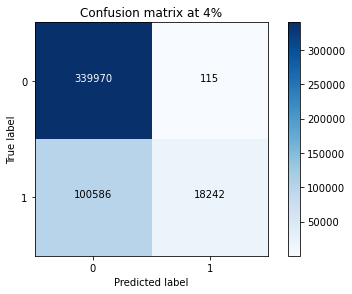

In [16]:
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = confusion_matrix(y_train, y_oof_binary)
class_names = [0, 1]
plt.figure()
plot_confusion_matrix(cm, classes=class_names, title=f'Confusion matrix at 4%')
plt.show()

In [17]:
test['prediction'] = y_test
test['prediction'].to_csv('submission_catboost.csv', index=True)

In [18]:
test

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_117_count,D_117_last,D_117_nunique,D_120_count,D_120_last,D_120_nunique,D_126_count,D_126_last,D_126_nunique,prediction
customer_ID,,,,,,,,,,,,,,,,,,,,,
00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7,0.601387,0.020190,0.568930,0.631315,0.568930,2.222222,3.527668,0,8,4,...,9,1,2,9,2,2,9,0,1,0.023237
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397d4263dafa1daedef5,0.862166,0.031436,0.794469,0.913501,0.841177,5.076923,6.034091,0,17,4,...,13,4,1,13,1,1,13,1,1,0.001909
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5e400fc98e7bd43ce8,0.748955,0.061456,0.673112,0.835114,0.697522,6.000000,9.000000,0,23,0,...,13,4,2,13,1,1,13,0,2,0.045625
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf6e56734528702d694,0.474728,0.028856,0.428457,0.514222,0.513186,15.846154,4.355957,7,23,11,...,13,5,3,13,1,2,13,1,1,0.203802
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a4693dd914fca22557,0.324100,0.049865,0.254478,0.425764,0.254478,11.846154,6.681394,1,26,26,...,13,1,1,13,2,2,13,0,1,0.834456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5d60460dba6dedc41e,0.631613,0.015759,0.597667,0.646915,0.646915,0.000000,0.000000,0,0,0,...,13,4,1,13,1,1,13,1,1,0.011852
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a4f0ca3de613b0b2ad,0.547049,0.053224,0.471303,0.634783,0.471303,1.769231,3.982333,0,14,0,...,13,4,1,13,1,2,13,1,1,0.784663
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475cb095d2443a68030f1,0.239070,0.048398,0.195671,0.316648,0.206425,7.769231,11.031424,0,38,0,...,13,4,1,13,1,2,13,1,1,0.391314
